# Homework #10:
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 11/2/2019|
|Updated | 11/3/2019|

## 17.5 Global Optimization I
We wish to find the ground state energy between three neutral atoms or molecules, $N=3$. To simplify the calculation, we'll use the _Lennard-Jones (LJ) potential_:

$$ V = 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right] \tag{1},$$

where $\varepsilon$ is the depth of the potential well, $\sigma$ is the finite distance at which the interparticle potential is zero, and $r$ is the distance between the particles. We will also assume $\varepsilon$ = $\sigma$ = 1.

In [1]:
def LJ(r):
    """
    Calculate and return the Lennard-Jones potential between two
    atoms as a function of separation distance.
    Input:
        r: interatomic separation distance.
    Output:
        Lennard-Jones potential with ε = σ = 1
    """
    r6 = r**6
    r12 = r6*r6
    return 4*(1/r12 - 1/r6)

Since $N=3$, the number of interatomic pairs will be

$$ \frac{N\times(N-1)}{2} = 3 \tag{2}.$$

Thus, we'll need to calculate the distance $r$ for each pair and evaluate its corresponding LJ$_3$ potential.

In [2]:
import numpy as np

def total_LJ_V(positions):
    """
    Calculate the total potential energy of N number of atoms using
    the Lennard-Jones potential.
    Input:
        positions: 3*N 1-D array which represents the atomic positions
                   (e.g., [x0, y0, z0, x1, y2, z1, ..., xn, yn, zn])
    Output:
        E: the total energy
    """
    E = 0
    N_atom = int(len(positions)/3)

    for i in range(N_atom - 1):
        for j in range(i + 1, N_atom):
            pos1 = positions[i*3:(i+1)*3]
            pos2 = positions[j*3:(j+1)*3]
            dist = np.linalg.norm(pos1 - pos2)
            E += LJ(dist)
            
    return E

Now that we have a way to calculate the total energy of $N$ atoms, using the LJ potential, next we need to randomly generate positions for these $N$ atoms. To do so, we'll generate a random sample for the $x, y,$ and $z$ coordinates of each atom to be within some cubic box with set length $L$.

In [3]:
def init_pos(N, L=1):
    """
    Randomly initialize the 3-D position of N atoms within a cube
    of length L.
    Input:
        N: the number of atoms
        L: 3-D boundary of random sample (e.g., length of cube)
    Output:
        3*N 1-D array of atomic positions
        (e.g., [x0, y0, z0, x1, y2, z1, ..., xn, yn, zn])
    """
    return L*np.random.random_sample((N*3,))

Before we attempt to find the _gound state_ of the LJ$_3$ potential for three atoms, let's go ahead and generate a random configuration of three atoms and visualize it using the ___Atomic Simulation Environment___ (ASE) library.

In [11]:
pos = init_pos(3)

In [12]:
# Visulization of the LJ clusters
from ase.visualize import view
from ase import Atoms

N = 3
cluster = Atoms('N'+str(N), positions=np.reshape(pos*2.0,[N,3]))
view(cluster, viewer='x3d')

<h4 align="center">$N = 3$ (random)</h4> 

Of course, the configuration isn't symmetric. Nonetheless, let's calculate it's LJ potential energy.

In [13]:
print("Total energy: ", total_LJ_V(pos))

Total energy:  2710119.8512915564


As we might have expected, this configuration corresponds to a high (positive) potential energy, and definitely does not represent the ground state configuration for three atoms.

Now let's see if we can _minimize_ the total energy _function_ to determine a minimum, hopefully corresponding to the ground state configuration (the global minimum).

In [14]:
from scipy.optimize import minimize

res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
print("Total energy: ", res.fun)

Total energy:  -2.999999999999746


This is using a single minimization pass, using the randomly generated spatial configuration. For reference, the energy value tabulated at the Cambridge LJ cluster database ([link](http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html)) for $N=3$ is "-3.000000."

Now let's visualize what this ground state configuration looks like.

In [15]:
ground = res.x # extract the spatial coordinates of the three atoms
               # corresponding to the minimum (ground state)
N = 3
cluster = Atoms('N'+str(N), positions=np.reshape(ground*2.0,[N,3]))
view(cluster, viewer='x3d')

<h4 align="center">$N = 3$ (ground state)</h4> 

We now see the expected symmetry that was missing in the earlier, purely random, configuration. The ground state for $N=3$ corresponds to each atom at the point of an _equilateral triangle_.

## 18.3 Global Optimization II

Now let's try to deteremine the ground state for $N=12$ atoms.

Try different minimization methods in scipy on larger systems ($N$ up to 20), and show 
1. the average number of attempts to find the ground state
2. the time costs


### Optional
try to improve the code to make it run faster, analyze the most time consuming part and give your solution

In [16]:
N = 12
pos = init_pos(N)
res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
print("Total energy: ", res.fun)

Total energy:  -19.765305565548356


This is for a single minimization pass, using a randomly generated spatial configuration for twelve atoms. For reference, the energy value tabulated at the Cambridge LJ cluster database ([link](http://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html)) for $N=12$ is -37.967600. This discrepancy suggests we likely found a _local_ minimum (the one closest to the random starting configuration), but not the _global_ minimum (i.e., ground state).

Before we try again, let's visualize what this state looks like.

In [17]:
ground = res.x
cluster = Atoms('N'+str(N), positions=np.reshape(ground*2.0,[N,3]))
view(cluster, viewer='x3d')

<h4 align="center">$N = 12$ (local min.)</h4> 

Since we're not guaranteed to reach the _global_ minimum with any single random configuration (as we do not know what the energy "landscape" of the potential function looks like), we should try multiple times, and hopefully the minimum of _that set_ will be closer to the true, global minimum (ground state). Of course, the more times we do this, the more confident we can be of finding the global minimum (i.e., as $N_{runs}\rightarrow \infty$).

In [18]:
import time

f_values = []
pos_values = []
N_runs = 50

timer_start = time.perf_counter() # start of timer
for i in range(N_runs):
    pos = init_pos(N)
    res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
    f_values.append(res.fun)
    pos_values.append(res.x)
    print('\rRUN {:d} OUT OF {:d}: Total Energy = {:.4f}'.format(i, N_runs, res.fun), flush=True, end='')
timer_end = time.perf_counter() # end timer
time = timer_end - timer_start
    
print('\nGround state energy:', min(f_values))
print("Total calculation time: {:.0f} sec".format(time, ))

RUN 49 OUT OF 50: Total Energy = -35.1149
Ground state energy: -37.967599562246974
Total calculation time: 209 sec


For reference, the Cambridge Cluster Database lists -37.967600.

We can plot a historgram of all our runs to start getting a picture of the energy landscape.

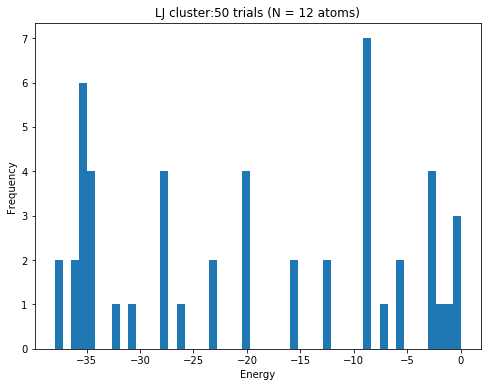

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=[8,6])
plt.title('LJ cluster:'+ str(N_runs)+ ' trials (N = ' + str(N)+' atoms)')
plt.hist(f_values, N_runs)
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

As we can see, the local minimum corresponding largest energy "basin" appears to center somwhere around -10. Meanwhile, the global minimum basin (ground state energy) is among the smallest.

Let's see what the ground state configuration of 12 atoms looks like.

In [20]:
min_index = f_values.index(min(f_values))
ground = pos_values[min_index]
cluster = Atoms('N'+str(N), positions=np.reshape(ground*2.0,[N,3]))
view(cluster, viewer='x3d')

<h4 align="center">$N = 12$ (ground state)</h4> 

As a comparison, we can visualize the configuration found at the Cambridge Cluster Database (CCD).

In [21]:
# data from http://doye.chem.ox.ac.uk/jon/structures/LJ/points/12
CCD = np.array([  0.2554245657,       -0.7597155830,        0.8059835272,
                  0.5283253377,        0.9897998883,        0.1821754467,
                 -0.5997802033,        0.8673465165,        0.4242568675,
                  1.0568739378,       -0.0157847459,        0.4180799298,
                 -0.7684429943,       -0.2139178301,        0.8097866524,
                 -0.2229503268,        0.7895914511,       -0.6395424769,
                  0.6115264731,       -0.7980514036,       -0.2670688620,
                 -0.4892364945,       -0.9175362229,       -0.0308514186,
                  0.7761020388,        0.2570139805,       -0.6432655993,
                 -1.0049747907,        0.0636802183,       -0.2610548345,
                 -0.1634049827,       -0.3001501148,       -0.9132836927,
                  0.0205374392,        0.0377238456,        0.1147844603])

cluster = Atoms('N'+str(N), positions=np.reshape(CCD*2.0,[N,3]))
view(cluster, viewer='x3d')

<h4 align="center">$N = 12$ (CCD ground state)</h4> 

### Just-in-time Optimization from _Numba_

Now that we must perform several minimizations from random starting configurations, for larger values of $N$, computational performance becomes extremely important. For example, it took about 200 seconds to complete 50 runs for $N = 12$; that's roughly 4 seconds per minimization. Let's see how much performance we can leverage by simply using _just-in-time_ (JIT) compilation using the ___Numba___ library.

In [22]:
from numba import jit

@jit
def LJ(r):
    """
    Calculate and return the Lennard-Jones potential between two
    atoms as a function of separation distance.
    Input:
        r: interatomic separation distance.
    Output:
        Lennard-Jones potential with ε = σ = 1
    """
    r6 = r**6
    r12 = r6*r6
    return 4*(1/r12 - 1/r6)

@jit
def total_LJ_V(positions):
    """
    Calculate the total potential energy of N number of atoms using
    the Lennard-Jones potential.
    Input:
        positions: 3*N 1-D array which represents the atomic positions
                   (e.g., [x0, y0, z0, x1, y2, z1, ..., xn, yn, zn])
    Output:
        E: the total energy
    """
    E = 0
    N_atom = int(len(positions)/3)

    for i in range(N_atom - 1):
        for j in range(i + 1, N_atom):
            pos1 = positions[i*3:(i+1)*3]
            pos2 = positions[j*3:(j+1)*3]
            dist = np.linalg.norm(pos1 - pos2)
            E += LJ(dist)
            
    return E

@jit
def init_pos(N, L=1):
    """
    Randomly initialize the 3-D position of N atoms within a cube
    of length L.
    Input:
        N: the number of atoms
        L: 3-D boundary of random sample (e.g., length of cube)
    Output:
        3*N 1-D array of atomic positions
        (e.g., [x0, y0, z0, x1, y2, z1, ..., xn, yn, zn])
    """
    return L*np.random.random_sample((N*3,))

In [23]:
import time

f_values = []
pos_values = []
N_runs = 50

timer_start = time.perf_counter()
for i in range(N_runs):
    pos = init_pos(N)
    res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
    f_values.append(res.fun)
    pos_values.append(res.x)
    print('\rRUN {:d} OUT OF {:d}: Total Energy = {:.4f}'.format(i, N_runs, res.fun), flush=True, end='')
timer_end = time.perf_counter()
time = timer_end - timer_start
    
print('\nGround state energy:', min(f_values))
print("Total calculation time: {:.0f} sec".format(time, ))

RUN 49 OUT OF 50: Total Energy = -10.1039
Ground state energy: -36.30679096534666
Total calculation time: 18 sec


Applying Numba's JIT compilation alone yields more than a 10x increase in performance. We can now compute an order of magnitude more runs and get a better picture of the energy landscape.

In [24]:
import time

f_values = []
pos_values = []
N_runs = 500

timer_start = time.perf_counter()
for i in range(N_runs):
    pos = init_pos(N)
    res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
    f_values.append(res.fun)
    pos_values.append(res.x)
    print('\rRUN {:d} OUT OF {:d}: Total Energy = {:.4f}'.format(i, N_runs, res.fun), flush=True, end='')
timer_end = time.perf_counter()
time = timer_end - timer_start
    
print('\nGround state energy:', min(f_values))
print("Total calculation time: {:.0f} sec".format(time, ))

RUN 499 OUT OF 500: Total Energy = -0.00002
Ground state energy: -37.967599562347495
Total calculation time: 160 sec


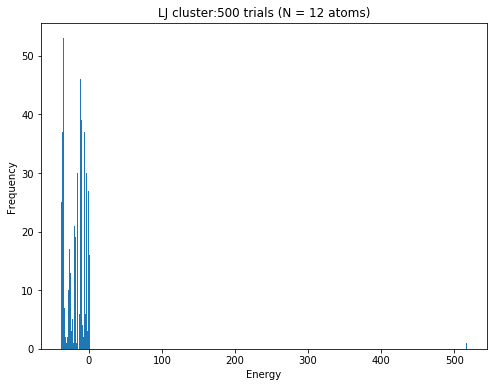

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=[8,6])
plt.title('LJ cluster:'+ str(N_runs)+ ' trials (N = ' + str(N)+' atoms)')
plt.hist(f_values, N_runs)
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

Now let's determine the ground state energy of $N = 20$ atoms.

In [20]:
import time

N = 20
f_values = []
pos_values = []
N_runs = 100

timer_start = time.perf_counter()
for i in range(N_runs):
    pos = init_pos(N)
    res = minimize(total_LJ_V, pos, method='CG', tol=1e-4)
    f_values.append(res.fun)
    pos_values.append(res.x)
    print('\rRUN {:d} OUT OF {:d}: Total Energy = {:.4f}'.format(i, N_runs, res.fun), flush=True, end='')
timer_end = time.perf_counter()
time = timer_end - timer_start
    
print('\nGround state energy:', min(f_values))
print("Total calculation time: {:.0f} sec".format(time, ))

RUN 99 OUT OF 100: Total Energy = -12.3031
Ground state energy: -77.17704256811288
Total calculation time: 411 sec


For reference, the CCD lists -77.177043 for $N = 20$, although it took this code almost 7 minutes (for 100 runs).

Let's see what the ground state configuration of 20 atoms looks like.

In [22]:
from ase.visualize import view
from ase import Atoms

min_index = f_values.index(min(f_values))
ground = pos_values[min_index]
cluster = Atoms('N'+str(N), positions=np.reshape(ground*2.0,[N,3]))
view(cluster, viewer='x3d')